In [1]:
# This notebook fits an initial model at alpha0
# then it refits alternative models for different alpha's

In [2]:
git_repo = '../../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib

# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib
import simulation_lib

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

import numpy as np
import scipy as sp

np.random.seed(453453)

import json 

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [3]:
# colors for plotting
import matplotlib.cm as cm

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

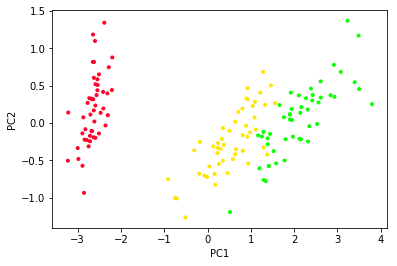

In [4]:
# load (or simulate) data
simulate = False
if not simulate:
    # load iris data
    dataset_name = 'iris'
    features, iris_species = utils_lib.load_data()
    dim = features.shape[1]
    
    # run PCA
    pca_fit = PCA()
    pca_fit.fit(features)
    pc_features = pca_fit.transform(features)
    
    # plot
    fig1 = plt.figure(1)
    fig = fig1.add_subplot(111)
    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
    fig.set_xlabel('PC1')
    fig.set_ylabel('PC2')
    
    
else:
    # Simulate data
    dataset_name = 'simulation'

    n_obs = 1000
    dim = 2
    true_k = 3
    features, true_z, true_components, true_centroids, true_covs, true_probs = \
        simulation_lib.simulate_data(n_obs, dim, true_k, separation=0.4)

    for k in range(true_k):
        plt.plot(features[true_components == k, 0], features[true_components == k, 1], '.')

# Set up the model

In [5]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(3.5)

prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [6]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(
    features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

In [7]:
# run k-means init
n_kmeans_init = 50
kmeans_init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)

In [22]:
kmeans_init_global_free_param[0:10]


array([ 1.39      , -1.15333333,  0.28393939,  0.18444444,  0.81121212,
       -0.84333333, -0.33083333,  0.72484848, -0.30333333, -0.21833333])

In [20]:
t0 = time.time()
model.objective.logger.print_every = 20
best_param, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    model.optimize_full(kmeans_init_global_free_param)
t_newton = time.time() - t0

assert converged
print('Done. Converged: ', converged)

Iter: 0	 RMSE: 5.4171664084976205	 Objective: 4857.435222221535
Iter: 20	 RMSE: 11.1988618231829	 Objective: 2228.7475920420443
Iter: 40	 RMSE: 14.134840715586062	 Objective: -88.794152205937
Iter: 60	 RMSE: 12.44929153853015	 Objective: -296.5477344117195
Iter: 80	 RMSE: 12.422491563165979	 Objective: -309.7648794792452
Iter: 100	 RMSE: 12.410315037661984	 Objective: -312.5194192916855
Iter: 120	 RMSE: 12.40759288049355	 Objective: -313.0903878425097
Iter: 140	 RMSE: 12.371463947395675	 Objective: -313.82471288711025
Iter: 160	 RMSE: 12.385089160526865	 Objective: -314.5146580406567
Iter: 180	 RMSE: 12.377474065213132	 Objective: -315.10347967509455
Iter: 200	 RMSE: 12.36289713120869	 Objective: -315.2039700857494
Iter: 220	 RMSE: 12.363021128947908	 Objective: -315.2980353597966
Iter: 240	 RMSE: 12.357823875993871	 Objective: -315.33302588430826
Iter: 260	 RMSE: 12.367897210937445	 Objective: -315.3465695424439
Iter: 280	 RMSE: 12.032515312527817	 Objective: -315.67186573473447
Iter:

In [9]:
kl_hessian = model.objective.fun_free_hessian(best_param)

In [18]:
# look at results
bnp_clusters = np.argmax(model.e_z, axis = 1)
bnp_centroids = model.vb_params['global']['centroids'].get()

bnp_cluster_infos = model.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)


e_num_clusers = gmm_utils.get_e_num_clusters_from_free_par(best_param, model)

print('Expected number of distinct clusters: ', e_num_clusers)

Expected number of distinct clusters:  4.933462247784094


In [11]:
# we plot in PCA space
bnp_centroids_pc, bnp_cluster_covs_pc = \
    utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

Text(0,0.5,'PC2')

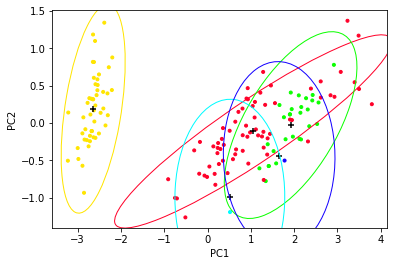

In [12]:
# plot results

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
# colors1_[0] = colors1[2]
# colors1_[1] = colors1[0]
# colors1_[2] = colors1[1]

utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

In [13]:
# save model

fit_dict = gmm_utils.get_checkpoint_dictionary(model, kl_hessian, seed=453453)
base_alpha = model.prior_params['alpha'].get()
filename = 'bnp_full_data_fit_alpha{}_{}.json'.format(base_alpha, dataset_name)
json_output_file = os.path.join(
    './iris_fits_for_nips/',
    filename)
print('saving fit dict to ', json_output_file)
with open(json_output_file, 'w') as outfile:
    json.dump(fit_dict, outfile)


saving fit dict to  ./iris_fits_for_nips/bnp_full_data_fit_alpha3.5_iris.json


# Fit multiple models and save them: 

In [14]:
# we use the original model as an initialization and refit for a range of alphas

In [15]:
alpha_vec = np.arange(start=1.0, stop=16, step=0.5)
# alpha_vec = np.array([1.0])
print(alpha_vec)

[ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5
  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5
 15.  15.5]


In [23]:

for i in range(len(alpha_vec)): 
    print('\n\nRunning for alpha={}'.format(alpha_vec[i]))
       
    # define prior
    prior_params = gmm_utils.get_default_prior_params(dim)
    prior_params['alpha'].set(alpha_vec[i])

    prior_params['prior_gamma_df'].set(8)
    prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

    # define model 
    k_approx = 12
    gh_deg = 8
    model_refit = gmm_utils.DPGaussianMixture(
        features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

    # initialize from the original model 
    init_global_free_param = deepcopy(best_param)
    
    # ...or from kmeans (this gives really erratic results)
    #init_global_free_param = deepcopy(kmeans_init_global_free_param)
    
    # fit model
    t0 = time.time()
    best_param_refit, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
        model_refit.optimize_full(init_global_free_param)
    t_newton = time.time() - t0

    assert converged
    print('Done. Converged: ', converged)

    # get KL
    kl_hessian = model_refit.objective.fun_free_hessian(best_param_refit)

    # save model
    fit_dict = gmm_utils.get_checkpoint_dictionary(model_refit, kl_hessian, seed=453453)
    alpha = model_refit.prior_params['alpha'].get()
    filename = 'bnp_full_data_fit_alpha{}_{}.json'.format(alpha, dataset_name)
    json_output_file = os.path.join(
        './iris_fits_for_nips/',
        filename)
    print('saving fit dict to ', json_output_file)
    with open(json_output_file, 'w') as outfile:
        json.dump(fit_dict, outfile)




Running for alpha=1.0
Iter: 0	 RMSE: 11.270059435185319	 Objective: -336.6523890677916
Iter: 1	 RMSE: 11.374005149338664	 Objective: -336.5281778508113
Iter: 2	 RMSE: 11.318739773838143	 Objective: -337.441062063117
Iter: 3	 RMSE: 11.526292449292194	 Objective: -329.341625605902
Iter: 4	 RMSE: 11.332327774715244	 Objective: -337.5089909535561
Iter: 5	 RMSE: 11.342672857005038	 Objective: -337.5834149733704
Iter: 6	 RMSE: 11.351310726819444	 Objective: -337.68181902070455
Iter: 7	 RMSE: 11.358555216846622	 Objective: -337.8154119050221
Iter: 8	 RMSE: 11.362429485015875	 Objective: -338.0358444959056
Iter: 9	 RMSE: 11.36482819134485	 Objective: -338.20902481686403
Iter: 10	 RMSE: 11.36530375102167	 Objective: -338.3525140728332
Iter: 11	 RMSE: 11.362847822746607	 Objective: -338.5897483825506
Iter: 12	 RMSE: 11.355842222556914	 Objective: -338.5779048285559
Iter: 13	 RMSE: 11.359019345496291	 Objective: -338.70670671610617
Iter: 14	 RMSE: 11.354444827228496	 Objective: -338.91941150997

Iter: 28	 RMSE: 11.34398734577624	 Objective: -336.4087842264492
Iter: 29	 RMSE: 11.334125679670166	 Objective: -336.51161113584305
Iter: 30	 RMSE: 11.336873220839001	 Objective: -336.62797186671713
Iter: 31	 RMSE: 11.442624138157793	 Objective: -336.50244274570235
Iter: 32	 RMSE: 11.3689865100431	 Objective: -336.66530136257757
Iter: 33	 RMSE: 11.36777589012315	 Objective: -336.7262104469833
Iter: 34	 RMSE: 11.360422116106273	 Objective: -336.80327121819073
Iter: 35	 RMSE: 11.35734509777428	 Objective: -336.65239791542666
Iter: 36	 RMSE: 11.359778893343654	 Objective: -336.8231692250115
Iter: 37	 RMSE: 11.357405769683615	 Objective: -336.85641537106864
Iter: 38	 RMSE: 11.351753348483804	 Objective: -336.6719838112665
Iter: 39	 RMSE: 11.356667059454717	 Objective: -336.86083015563054
Iter: 40	 RMSE: 11.355763157981318	 Objective: -336.86777980267027
Iter: 41	 RMSE: 11.35426138439673	 Objective: -336.88068217535607
Iter: 42	 RMSE: 11.35249119033448	 Objective: -336.9017246721064
Iter: 4

Iter: 35	 RMSE: 11.319776127735029	 Objective: -332.27254726359183
Iter: 36	 RMSE: 11.326386551304969	 Objective: -332.2994108722305
Iter: 37	 RMSE: 11.31977961408655	 Objective: -332.3020889527597
Iter: 38	 RMSE: 11.319212738641427	 Objective: -332.30733759003283
Iter: 39	 RMSE: 11.316959110680186	 Objective: -332.3251085006269
Iter: 40	 RMSE: 11.345726827676891	 Objective: -332.3053132196315
Iter: 41	 RMSE: 11.326677340647556	 Objective: -332.3331861140757
Iter: 42	 RMSE: 11.329045605677774	 Objective: -332.3389737733973
Iter: 43	 RMSE: 11.327498800802584	 Objective: -332.34982529295024
Iter: 44	 RMSE: 11.32582084935553	 Objective: -332.3672887262926
Iter: 45	 RMSE: 11.323365757017942	 Objective: -332.38582768274733
Iter: 46	 RMSE: 11.32057245386801	 Objective: -332.3773209385653
Iter: 47	 RMSE: 11.322220759608356	 Objective: -332.39253509149194
Iter: 48	 RMSE: 11.322347010969652	 Objective: -332.3911414923214
Iter: 49	 RMSE: 11.322262790409297	 Objective: -332.3953619945541
Iter: 50

Iter: 28	 RMSE: 11.301157314141893	 Objective: -328.44645870134843
Iter: 29	 RMSE: 11.296286652674544	 Objective: -328.458924971893
Iter: 30	 RMSE: 11.292554050597273	 Objective: -328.4766331667376
Iter: 31	 RMSE: 11.295979180338497	 Objective: -328.4894273895629
Iter: 32	 RMSE: 11.315568814012419	 Objective: -328.4811819708265
Iter: 33	 RMSE: 11.303345882962109	 Objective: -328.494320336982
Iter: 34	 RMSE: 11.302660290109877	 Objective: -328.5029982729698
Iter: 35	 RMSE: 11.298278546325806	 Objective: -328.49883088698834
Iter: 36	 RMSE: 11.300879629199333	 Objective: -328.5065280582941
Iter: 37	 RMSE: 11.299112994732162	 Objective: -328.509030109741
Iter: 38	 RMSE: 11.297966317236755	 Objective: -328.5135334457517
Iter: 39	 RMSE: 11.306465374598647	 Objective: -328.50733188029056
Iter: 40	 RMSE: 11.300466735230684	 Objective: -328.5148882123566
Iter: 41	 RMSE: 11.303684879485095	 Objective: -328.51643319609076
Iter: 42	 RMSE: 11.302603730415466	 Objective: -328.5193494223091
Iter: 43	

Iter: 58	 RMSE: 11.282589737909703	 Objective: -325.1331489886504
Iter: 59	 RMSE: 11.282594457072662	 Objective: -325.1331502206874
Iter: 60	 RMSE: 11.282625036317748	 Objective: -325.1331509428246
Iter: 61	 RMSE: 11.282618266968777	 Objective: -325.133151315024
Iter: 62	 RMSE: 11.282602351137811	 Objective: -325.13315159174863
Iter: 63	 RMSE: 11.282578601182903	 Objective: -325.1331517919118
Iter: 64	 RMSE: 11.282564548190633	 Objective: -325.13315174509995
Iter: 65	 RMSE: 11.282572303016558	 Objective: -325.1331518825071
Iter: 66	 RMSE: 11.28256874995075	 Objective: -325.13315198329593
Iter: 67	 RMSE: 11.282559380589722	 Objective: -325.13315200948415
Iter: 68	 RMSE: 11.282555881638084	 Objective: -325.1331520478861
Iter: 69	 RMSE: 11.282549504424246	 Objective: -325.13315209397194
Iter: 70	 RMSE: 11.282539486086513	 Objective: -325.1331520981661
Iter: 71	 RMSE: 11.282538555286639	 Objective: -325.1331521049494
Iter: 72	 RMSE: 11.282539289827898	 Objective: -325.1331521149082
Iter: 7

Iter: 90	 RMSE: 11.267591004674731	 Objective: -319.31383644736997
Iter: 91	 RMSE: 11.267592161470125	 Objective: -319.3138364494733
Iter: 92	 RMSE: 11.267592044282425	 Objective: -319.3138364483162
Iter: 93	 RMSE: 11.267592115934587	 Objective: -319.3138364502573
Iter: 94	 RMSE: 11.267591698720722	 Objective: -319.3138364512506
Iter: 95	 RMSE: 11.26759078845425	 Objective: -319.3138364511932
Iter: 96	 RMSE: 11.267591268255575	 Objective: -319.3138364514895
Iter: 97	 RMSE: 11.267590850931983	 Objective: -319.3138364518093
Optimization terminated successfully.
         Current function value: -319.313836
         Iterations: 82
         Function evaluations: 98
         Gradient evaluations: 98
Iter: 98	 RMSE: 11.267590850931983	 Objective: -319.3138364518072
Iter: 99	 RMSE: 11.267590739346158	 Objective: -319.31383645208166
Optimization terminated successfully.
         Current function value: -319.313836
         Iterations: 1
         Function evaluations: 2
         Gradient evaluat

Iter: 108	 RMSE: 11.261478632380845	 Objective: -316.806609048297
Iter: 109	 RMSE: 11.261478768726402	 Objective: -316.8066090483965
Optimization terminated successfully.
         Current function value: -316.806609
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. Converged:  True
saving fit dict to  ./iris_fits_for_nips/bnp_full_data_fit_alpha4.5_iris.json


Running for alpha=5.0
Iter: 0	 RMSE: 11.270059435185319	 Objective: -313.32476677199423
Iter: 1	 RMSE: 11.160307324054138	 Objective: -311.2874250898198
Iter: 2	 RMSE: 11.244336315561602	 Objective: -313.577447523491
Iter: 3	 RMSE: 11.177017110565494	 Objective: -310.5162893146801
Iter: 4	 RMSE: 11.238368944130876	 Objective: -313.5954192653338
Iter: 5	 RMSE: 11.234225403582794	 Objective: -313.6125827722738
Iter: 6	 RMSE: 11.231918776552085	 Objective: -313.637175822063
Iter: 7	 RMSE: 11.230173827663092	 Objective: -313.674268055635
Iter: 8	 RMSE: 11.23

Iter: 10	 RMSE: 11.227658896500708	 Objective: -311.1909315582984
Iter: 11	 RMSE: 11.224801374490031	 Objective: -311.2682853594168
Iter: 12	 RMSE: 11.226144061495463	 Objective: -311.3266271360777
Iter: 13	 RMSE: 11.227727285362452	 Objective: -311.3434093575811
Iter: 14	 RMSE: 11.228127702318316	 Objective: -311.3716524211459
Iter: 15	 RMSE: 11.228793225363162	 Objective: -311.4130927473662
Iter: 16	 RMSE: 11.229707072270676	 Objective: -311.4245506787893
Iter: 17	 RMSE: 11.229085894257464	 Objective: -311.4442497504133
Iter: 18	 RMSE: 11.229941964000174	 Objective: -311.47341088939476
Iter: 19	 RMSE: 11.228282932876821	 Objective: -311.524369252867
Iter: 20	 RMSE: 11.233040357616577	 Objective: -311.5809041427666
Iter: 21	 RMSE: 11.231537209896096	 Objective: -311.6706670542875
Iter: 22	 RMSE: 11.239468824827672	 Objective: -311.7911398175624
Iter: 23	 RMSE: 11.264490493259702	 Objective: -311.38756206008736
Iter: 24	 RMSE: 11.242407644708242	 Objective: -311.81396301559505
Iter: 25

Iter: 28	 RMSE: 11.238711973262859	 Objective: -309.698451867188
Iter: 29	 RMSE: 11.239950512686082	 Objective: -309.73860572777687
Iter: 30	 RMSE: 11.240254456876816	 Objective: -309.7834292686484
Iter: 31	 RMSE: 11.229215135723319	 Objective: -309.82391063847103
Iter: 32	 RMSE: 11.234917025288377	 Objective: -309.89216130426456
Iter: 33	 RMSE: 11.183168766487503	 Objective: -309.7658608138047
Iter: 34	 RMSE: 11.221399308290911	 Objective: -309.9097642754535
Iter: 35	 RMSE: 11.21722984846823	 Objective: -309.93780134747874
Iter: 36	 RMSE: 11.223465702907994	 Objective: -309.9736803276958
Iter: 37	 RMSE: 11.246388138819224	 Objective: -310.0132419259089
Iter: 38	 RMSE: 11.258823603872356	 Objective: -310.0431737168654
Iter: 39	 RMSE: 11.254834429841475	 Objective: -310.061834877647
Iter: 40	 RMSE: 11.251477977026335	 Objective: -310.0179901282241
Iter: 41	 RMSE: 11.25412400629774	 Objective: -310.0661335719387
Iter: 42	 RMSE: 11.25436045406182	 Objective: -310.0742430025195
Iter: 43	 R

Iter: 50	 RMSE: 11.23676160757177	 Objective: -308.2896123500416
Iter: 51	 RMSE: 11.237498958830509	 Objective: -308.29939400486126
Iter: 52	 RMSE: 11.238583805002792	 Objective: -308.3020497145174
Iter: 53	 RMSE: 11.239492234313756	 Objective: -308.3056524867836
Iter: 54	 RMSE: 11.239693236617665	 Objective: -308.3091989254281
Iter: 55	 RMSE: 11.236483980945314	 Objective: -308.30426458583713
Iter: 56	 RMSE: 11.238724982061642	 Objective: -308.31025348617675
Iter: 57	 RMSE: 11.237022562900485	 Objective: -308.3098085886817
Iter: 58	 RMSE: 11.238018543127255	 Objective: -308.3106966985807
Iter: 59	 RMSE: 11.23810960400883	 Objective: -308.3110916276694
Iter: 60	 RMSE: 11.23804866702366	 Objective: -308.31139533905855
Iter: 61	 RMSE: 11.237790726263047	 Objective: -308.31167700853547
Iter: 62	 RMSE: 11.237611662914823	 Objective: -308.31182014906057
Iter: 63	 RMSE: 11.237191612191397	 Objective: -308.3119472113479
Iter: 64	 RMSE: 11.236657085343765	 Objective: -308.31199057528175
Iter: 

Iter: 75	 RMSE: 11.225765564418232	 Objective: -306.48531130203156
Iter: 76	 RMSE: 11.225774166926032	 Objective: -306.48531017929946
Iter: 77	 RMSE: 11.225767839961556	 Objective: -306.48531146917566
Iter: 78	 RMSE: 11.225764207204614	 Objective: -306.48531169187356
Iter: 79	 RMSE: 11.225764299218978	 Objective: -306.48531167886296
Iter: 80	 RMSE: 11.225764251468581	 Objective: -306.48531180118164
Iter: 81	 RMSE: 11.225776075928026	 Objective: -306.4853119106498
Iter: 82	 RMSE: 11.225789565622295	 Objective: -306.4853118370155
Iter: 83	 RMSE: 11.225781135110513	 Objective: -306.4853119521237
Iter: 84	 RMSE: 11.225785091393421	 Objective: -306.4853120000771
Iter: 85	 RMSE: 11.225795020699952	 Objective: -306.4853120298549
Iter: 86	 RMSE: 11.22580032840018	 Objective: -306.48531205256666
Iter: 87	 RMSE: 11.225793687418077	 Objective: -306.48531205841664
Iter: 88	 RMSE: 11.225791360162251	 Objective: -306.48531206651154
Iter: 89	 RMSE: 11.225793486908158	 Objective: -306.4853120705365
It

Iter: 97	 RMSE: 11.205800477010712	 Objective: -304.77089833184215
Iter: 98	 RMSE: 11.205800407789214	 Objective: -304.7708983319675
Optimization terminated successfully.
         Current function value: -304.770898
         Iterations: 82
         Function evaluations: 99
         Gradient evaluations: 99
Iter: 99	 RMSE: 11.205800407789214	 Objective: -304.7708983319659
Iter: 100	 RMSE: 11.205800600875842	 Objective: -304.77089833213245
Optimization terminated successfully.
         Current function value: -304.770898
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. Converged:  True
saving fit dict to  ./iris_fits_for_nips/bnp_full_data_fit_alpha7.5_iris.json


Running for alpha=8.0
Iter: 0	 RMSE: 11.270059435185319	 Objective: -295.8290500501462
Iter: 1	 RMSE: 11.160307324060817	 Objective: -297.53861555092584
Iter: 2	 RMSE: 10.990338973207265	 Objective: -279.5731916768042
Iter: 3	 RMSE: 11.145110907590192

Iter: 116	 RMSE: 11.001984326286788	 Objective: -304.0493695576233
Iter: 117	 RMSE: 11.00198473445472	 Objective: -304.04936955771893
Iter: 118	 RMSE: 11.001984602722672	 Objective: -304.04936955789384
Iter: 119	 RMSE: 11.001984353797212	 Objective: -304.0493695581487
Iter: 120	 RMSE: 11.001983919163601	 Objective: -304.0493695582422
Iter: 121	 RMSE: 11.001983851335378	 Objective: -304.0493695583555
Iter: 122	 RMSE: 11.001983908875358	 Objective: -304.0493695583292
Iter: 123	 RMSE: 11.001983871965583	 Objective: -304.04936955836826
Iter: 124	 RMSE: 11.00198391827761	 Objective: -304.0493695583822
Optimization terminated successfully.
         Current function value: -304.049370
         Iterations: 103
         Function evaluations: 125
         Gradient evaluations: 125
Iter: 125	 RMSE: 11.00198391827761	 Objective: -304.04936955838303
Iter: 126	 RMSE: 11.001983916045448	 Objective: -304.0493695584096
Optimization terminated successfully.
         Current function value: -304.049370
 

Iter: 107	 RMSE: 10.994146880360525	 Objective: -302.8288272644255
Iter: 108	 RMSE: 10.994147028770291	 Objective: -302.82882726566197
Iter: 109	 RMSE: 10.994146867225702	 Objective: -302.82882726591987
Iter: 110	 RMSE: 10.994146511881736	 Objective: -302.82882726604385
Iter: 111	 RMSE: 10.994146317895174	 Objective: -302.8288272660071
Iter: 112	 RMSE: 10.994146427291316	 Objective: -302.8288272660995
Iter: 113	 RMSE: 10.994146346949798	 Objective: -302.8288272661297
Iter: 114	 RMSE: 10.994146339122443	 Objective: -302.8288272661294
Iter: 115	 RMSE: 10.994146343091812	 Objective: -302.82882726613434
Optimization terminated successfully.
         Current function value: -302.828827
         Iterations: 98
         Function evaluations: 116
         Gradient evaluations: 116
Iter: 116	 RMSE: 10.99414634309181	 Objective: -302.8288272661357
Iter: 117	 RMSE: 10.994146366091785	 Objective: -302.82882726614423
Optimization terminated successfully.
         Current function value: -302.828827

Iter: 106	 RMSE: 10.988365987217577	 Objective: -301.6543091537866
Iter: 107	 RMSE: 10.98836597554028	 Objective: -301.65430915413236
Iter: 108	 RMSE: 10.988366004997562	 Objective: -301.65430915426947
Iter: 109	 RMSE: 10.988366092627553	 Objective: -301.6543091542849
Iter: 110	 RMSE: 10.988366050985698	 Objective: -301.6543091543439
Iter: 111	 RMSE: 10.988366152356043	 Objective: -301.6543091543879
Iter: 112	 RMSE: 10.988366182674989	 Objective: -301.6543091543723
Iter: 113	 RMSE: 10.988366164751753	 Objective: -301.65430915440265
Optimization terminated successfully.
         Current function value: -301.654309
         Iterations: 96
         Function evaluations: 114
         Gradient evaluations: 114
Iter: 114	 RMSE: 10.988366164751755	 Objective: -301.65430915440345
Iter: 115	 RMSE: 10.988366034758554	 Objective: -301.6543091544491
Optimization terminated successfully.
         Current function value: -301.654309
         Iterations: 1
         Function evaluations: 2
         Gr

Iter: 109	 RMSE: 7.719504980727951	 Objective: -313.9985291539794
Iter: 110	 RMSE: 7.688513765367897	 Objective: -314.23430513268806
Iter: 111	 RMSE: 7.688639567251481	 Objective: -314.59217765941565
Iter: 112	 RMSE: 7.701507560354607	 Objective: -315.0945651666675
Iter: 113	 RMSE: 7.692338276799418	 Objective: -315.6018147916067
Iter: 114	 RMSE: 7.715453389210489	 Objective: -315.58923922959764
Iter: 115	 RMSE: 7.703292240522182	 Objective: -315.85936330633524
Iter: 116	 RMSE: 7.71562256604127	 Objective: -315.969760282227
Iter: 117	 RMSE: 7.710938882025926	 Objective: -316.1335543967883
Iter: 118	 RMSE: 7.705840851396821	 Objective: -316.2715889644586
Iter: 119	 RMSE: 7.704291505768046	 Objective: -316.333411258552
Iter: 120	 RMSE: 7.703129310500655	 Objective: -316.40115480301785
Iter: 121	 RMSE: 7.701372672777768	 Objective: -316.452528675227
Iter: 122	 RMSE: 7.70555940025719	 Objective: -316.4885866874352
Iter: 123	 RMSE: 7.709525477574379	 Objective: -316.52582985137644
Iter: 124

Iter: 38	 RMSE: 11.074511564955564	 Objective: -297.82434671225013
Iter: 39	 RMSE: 11.091691235944323	 Objective: -297.97634440009824
Iter: 40	 RMSE: 11.071944352838058	 Objective: -298.0271004883099
Iter: 41	 RMSE: 11.06004444693986	 Objective: -298.11060582616034
Iter: 42	 RMSE: 11.057062106706013	 Objective: -298.2587559970614
Iter: 43	 RMSE: 11.052340003614407	 Objective: -298.4494122209267
Iter: 44	 RMSE: 11.038978544812494	 Objective: -298.6339189298266
Iter: 45	 RMSE: 11.039235197677014	 Objective: -298.8738568310705
Iter: 46	 RMSE: 11.024535891728453	 Objective: -299.0568956323149
Iter: 47	 RMSE: 11.012722510697087	 Objective: -298.9449050313484
Iter: 48	 RMSE: 11.019551997544927	 Objective: -299.1290115365042
Iter: 49	 RMSE: 11.020813337601131	 Objective: -299.25784595469975
Iter: 50	 RMSE: 11.026202763696766	 Objective: -299.45737761699104
Iter: 51	 RMSE: 11.033209989320575	 Objective: -299.7345268530281
Iter: 52	 RMSE: 11.048688403909312	 Objective: -300.0916150690172
Iter: 

Iter: 168	 RMSE: 7.737634905555174	 Objective: -316.17757230569833
Iter: 169	 RMSE: 7.737636326388996	 Objective: -316.1775724815813
Iter: 170	 RMSE: 7.73763740280162	 Objective: -316.17757261031227
Iter: 171	 RMSE: 7.737632567897507	 Objective: -316.177572705159
Iter: 172	 RMSE: 7.73762643700381	 Objective: -316.17757275797675
Iter: 173	 RMSE: 7.737624774537754	 Objective: -316.1775727808377
Iter: 174	 RMSE: 7.737624881938914	 Objective: -316.1775727881929
Iter: 175	 RMSE: 7.737625567093926	 Objective: -316.17757279090546
Iter: 176	 RMSE: 7.737626209748563	 Objective: -316.17757279191574
Iter: 177	 RMSE: 7.737626230285494	 Objective: -316.17757279243165
Iter: 178	 RMSE: 7.73762637238524	 Objective: -316.17757279255017
Iter: 179	 RMSE: 7.737626440728659	 Objective: -316.1775727925812
Iter: 180	 RMSE: 7.737626345710075	 Objective: -316.177572792591
Iter: 181	 RMSE: 7.737626328907357	 Objective: -316.1775727925941
Optimization terminated successfully.
         Current function value: -31

Iter: 106	 RMSE: 7.659281750310625	 Objective: -315.0361279669636
Iter: 107	 RMSE: 7.668034402006297	 Objective: -315.07806260177745
Iter: 108	 RMSE: 7.672689190848379	 Objective: -315.13971657726705
Iter: 109	 RMSE: 7.681271374557035	 Objective: -315.21092073455486
Iter: 110	 RMSE: 7.690955682562035	 Objective: -315.2497194312481
Iter: 111	 RMSE: 7.690052230166591	 Objective: -315.29462541288206
Iter: 112	 RMSE: 7.682479385537196	 Objective: -315.3241554851883
Iter: 113	 RMSE: 7.677493173741319	 Objective: -315.35076254107827
Iter: 114	 RMSE: 7.672332010414673	 Objective: -315.3752451811368
Iter: 115	 RMSE: 7.672072752784407	 Objective: -315.3775037126676
Iter: 116	 RMSE: 7.672075328426653	 Objective: -315.3882397100451
Iter: 117	 RMSE: 7.672528873697288	 Objective: -315.40207166056086
Iter: 118	 RMSE: 7.673822049505671	 Objective: -315.4056240556139
Iter: 119	 RMSE: 7.6736672670369686	 Objective: -315.41150312836595
Iter: 120	 RMSE: 7.6734817629349195	 Objective: -315.42023206548606


Iter: 50	 RMSE: 11.04233768613836	 Objective: -298.2796383543504
Iter: 51	 RMSE: 11.050576863100181	 Objective: -298.56501290449654
Iter: 52	 RMSE: 11.048366472749485	 Objective: -298.7512763819305
Iter: 53	 RMSE: 11.040491555616105	 Objective: -299.05276382594076
Iter: 54	 RMSE: 11.029988945944202	 Objective: -299.41200490145195
Iter: 55	 RMSE: 11.005721752197852	 Objective: -299.71211821832406
Iter: 56	 RMSE: 10.990060658771172	 Objective: -299.7974188154377
Iter: 57	 RMSE: 10.98138592671164	 Objective: -299.9461035856006
Iter: 58	 RMSE: 10.971436503049636	 Objective: -300.18948055887176
Iter: 59	 RMSE: 10.938072553957937	 Objective: -300.48682617492125
Iter: 60	 RMSE: 10.907426965026778	 Objective: -300.43040641689527
Iter: 61	 RMSE: 10.9237449440492	 Objective: -300.62658180882795
Iter: 62	 RMSE: 10.889034680643292	 Objective: -300.60473803729474
Iter: 63	 RMSE: 10.908079734821095	 Objective: -300.69290381225426
Iter: 64	 RMSE: 10.882093178284284	 Objective: -300.7197784585371
Iter

Iter: 176	 RMSE: 7.7362219842828495	 Objective: -314.975730036152
Iter: 177	 RMSE: 7.736222005809049	 Objective: -314.97573003615526
Optimization terminated successfully.
         Current function value: -314.975730
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. Converged:  True
saving fit dict to  ./iris_fits_for_nips/bnp_full_data_fit_alpha11.0_iris.json


Running for alpha=11.5
Iter: 0	 RMSE: 11.270059435185319	 Objective: -275.4173805413235
Iter: 1	 RMSE: 11.160307324062279	 Objective: -281.4983377554164
Iter: 2	 RMSE: 10.534360737338417	 Objective: -206.5531684874985
Iter: 3	 RMSE: 11.13887344328952	 Objective: -281.85942154889193
Iter: 4	 RMSE: 11.122465469177483	 Objective: -282.1388437371432
Iter: 5	 RMSE: 11.118790720392935	 Objective: -282.58677260540327
Iter: 6	 RMSE: 11.11748359263149	 Objective: -283.35526903852565
Iter: 7	 RMSE: 11.132017216023542	 Objective: -284.35665871577874
Iter: 8	 RMSE:

Iter: 118	 RMSE: 7.7400244353580145	 Objective: -314.3138257704135
Iter: 119	 RMSE: 7.741414350520065	 Objective: -314.3108958785254
Iter: 120	 RMSE: 7.740554739337243	 Objective: -314.3157401482465
Iter: 121	 RMSE: 7.741584925952203	 Objective: -314.3172587972533
Iter: 122	 RMSE: 7.741670908296014	 Objective: -314.31791378384656
Iter: 123	 RMSE: 7.741778462938167	 Objective: -314.31862055479604
Iter: 124	 RMSE: 7.742092681097666	 Objective: -314.3192383363029
Iter: 125	 RMSE: 7.742474054320813	 Objective: -314.31918642948375
Iter: 126	 RMSE: 7.7422718754169875	 Objective: -314.31944059258785
Iter: 127	 RMSE: 7.742396344211609	 Objective: -314.31970059809055
Iter: 128	 RMSE: 7.742526089731793	 Objective: -314.3200534652592
Iter: 129	 RMSE: 7.7424800034326635	 Objective: -314.3201821761039
Iter: 130	 RMSE: 7.742456131351205	 Objective: -314.32037065180424
Iter: 131	 RMSE: 7.742384591816797	 Objective: -314.32059516103493
Iter: 132	 RMSE: 7.742058710263481	 Objective: -314.3205968710448


Iter: 67	 RMSE: 9.370949202256591	 Objective: -300.6801988100201
Iter: 68	 RMSE: 9.228098824386347	 Objective: -301.1788402696243
Iter: 69	 RMSE: 8.994048495245755	 Objective: -301.5843039474908
Iter: 70	 RMSE: 8.81013234779816	 Objective: -302.31296581633586
Iter: 71	 RMSE: 8.588674856753247	 Objective: -303.55994814443983
Iter: 72	 RMSE: 8.272761878942969	 Objective: -305.3383830050448
Iter: 73	 RMSE: 7.990422487314651	 Objective: -305.40499776826243
Iter: 74	 RMSE: 8.10086860773128	 Objective: -306.3096158235551
Iter: 75	 RMSE: 7.988737561878567	 Objective: -306.563444116177
Iter: 76	 RMSE: 7.964459309022117	 Objective: -306.98924510543196
Iter: 77	 RMSE: 7.944869351891003	 Objective: -307.6470127465951
Iter: 78	 RMSE: 7.883229601265978	 Objective: -308.30125978597414
Iter: 79	 RMSE: 7.843874642345548	 Objective: -308.66075566535295
Iter: 80	 RMSE: 7.809172403428762	 Objective: -309.1446966381804
Iter: 81	 RMSE: 7.766967985059839	 Objective: -309.6584862167085
Iter: 82	 RMSE: 7.7155

Iter: 19	 RMSE: 11.1819847404265	 Objective: -285.23326786427134
Iter: 20	 RMSE: 11.151293343559308	 Objective: -285.81570421513163
Iter: 21	 RMSE: 11.174763679945023	 Objective: -286.4239169270173
Iter: 22	 RMSE: 11.185526804473664	 Objective: -287.0594841609785
Iter: 23	 RMSE: 11.210012039236144	 Objective: -287.18823026042315
Iter: 24	 RMSE: 11.214832654987482	 Objective: -287.42393555110624
Iter: 25	 RMSE: 11.203783757205615	 Objective: -287.793544500745
Iter: 26	 RMSE: 11.174840031743859	 Objective: -288.3248664247865
Iter: 27	 RMSE: 11.18651273152914	 Objective: -289.1570936260525
Iter: 28	 RMSE: 11.131697979367035	 Objective: -289.7777244091828
Iter: 29	 RMSE: 11.053502613563499	 Objective: -290.42950734414256
Iter: 30	 RMSE: 11.020608403351146	 Objective: -290.5571910889718
Iter: 31	 RMSE: 11.033895076577133	 Objective: -290.817539484286
Iter: 32	 RMSE: 11.02340965055332	 Objective: -291.37166186205764
Iter: 33	 RMSE: 10.991059815423286	 Objective: -291.77934262347367
Iter: 34	

Iter: 145	 RMSE: 7.693260517078758	 Objective: -313.02418913366455
Iter: 146	 RMSE: 7.693279936240664	 Objective: -313.0241903985114
Iter: 147	 RMSE: 7.693290141276473	 Objective: -313.0241915187033
Iter: 148	 RMSE: 7.693289778740976	 Objective: -313.0241920203148
Iter: 149	 RMSE: 7.693292666069811	 Objective: -313.02419251754117
Iter: 150	 RMSE: 7.6932890521527035	 Objective: -313.02419285790376
Iter: 151	 RMSE: 7.693269937038765	 Objective: -313.0241929024924
Iter: 152	 RMSE: 7.693267293557105	 Objective: -313.02419297951246
Iter: 153	 RMSE: 7.693267191250617	 Objective: -313.0241930999124
Iter: 154	 RMSE: 7.693263153778867	 Objective: -313.0241931474662
Iter: 155	 RMSE: 7.693260510907905	 Objective: -313.0241931491172
Iter: 156	 RMSE: 7.693261809167107	 Objective: -313.02419317190044
Iter: 157	 RMSE: 7.693260525376055	 Objective: -313.0241931825418
Iter: 158	 RMSE: 7.693260996012919	 Objective: -313.0241931909345
Iter: 159	 RMSE: 7.6932613861986905	 Objective: -313.0241931723429
Ite

Iter: 97	 RMSE: 7.661689994644995	 Objective: -312.1383899118748
Iter: 98	 RMSE: 7.66052482236479	 Objective: -312.18452877587544
Iter: 99	 RMSE: 7.6615841810635645	 Objective: -312.23934009782965
Iter: 100	 RMSE: 7.66475682054993	 Objective: -312.2816083260302
Iter: 101	 RMSE: 7.663093600499427	 Objective: -312.32864083386823
Iter: 102	 RMSE: 7.665012053108625	 Objective: -312.3672799265375
Iter: 103	 RMSE: 7.675055524106776	 Objective: -312.3733763869808
Iter: 104	 RMSE: 7.675535778642057	 Objective: -312.3845578167446
Iter: 105	 RMSE: 7.676332267246978	 Objective: -312.40396474954304
Iter: 106	 RMSE: 7.678912282289058	 Objective: -312.43106671238564
Iter: 107	 RMSE: 7.68202225590471	 Objective: -312.44720459067423
Iter: 108	 RMSE: 7.686597576852613	 Objective: -312.4619966168253
Iter: 109	 RMSE: 7.688253059623853	 Objective: -312.4614289639897
Iter: 110	 RMSE: 7.687396928548548	 Objective: -312.4681648617536
Iter: 111	 RMSE: 7.686205998469799	 Objective: -312.4749623232611
Iter: 112

Iter: 47	 RMSE: 11.068162261818635	 Objective: -294.9654130321007
Iter: 48	 RMSE: 11.046590527130865	 Objective: -295.41498473023637
Iter: 49	 RMSE: 11.052258089699373	 Objective: -295.8819572645399
Iter: 50	 RMSE: 11.031833244025462	 Objective: -296.15687016778844
Iter: 51	 RMSE: 11.013176816474687	 Objective: -296.4862964770303
Iter: 52	 RMSE: 10.969233533480624	 Objective: -296.86186484513735
Iter: 53	 RMSE: 10.945618035917175	 Objective: -297.0928659136189
Iter: 54	 RMSE: 10.887420460263584	 Objective: -297.29051250396753
Iter: 55	 RMSE: 10.82872778349176	 Objective: -297.41878065263825
Iter: 56	 RMSE: 10.783901782459628	 Objective: -297.54982849682284
Iter: 57	 RMSE: 10.739608608608204	 Objective: -297.5968177021902
Iter: 58	 RMSE: 10.710249523413179	 Objective: -297.6760956555306
Iter: 59	 RMSE: 10.637991580081215	 Objective: -297.80614597278094
Iter: 60	 RMSE: 10.473887274133482	 Objective: -298.0298990771472
Iter: 61	 RMSE: 10.074537486392078	 Objective: -298.22968480154327
Ite

saving fit dict to  ./iris_fits_for_nips/bnp_full_data_fit_alpha13.5_iris.json


Running for alpha=14.0
Iter: 0	 RMSE: 11.270059435185319	 Objective: -260.8376166064501
Iter: 1	 RMSE: 11.160307324062726	 Objective: -270.0409964728973
Iter: 2	 RMSE: 10.248457024272009	 Objective: -172.10871960470445
Iter: 3	 RMSE: 11.134977004630004	 Objective: -270.6068545147981
Iter: 4	 RMSE: 11.11557655199023	 Objective: -271.0540885477624
Iter: 5	 RMSE: 11.111454668587768	 Objective: -271.7731027376983
Iter: 6	 RMSE: 11.110296709644333	 Objective: -273.00686840939056
Iter: 7	 RMSE: 11.133551255293128	 Objective: -274.4628655997441
Iter: 8	 RMSE: 11.153658406592726	 Objective: -275.4915104650046
Iter: 9	 RMSE: 11.166959805827544	 Objective: -274.590058147595
Iter: 10	 RMSE: 11.156832235540794	 Objective: -275.8538953073256
Iter: 11	 RMSE: 11.157848944184009	 Objective: -276.4181817136724
Iter: 12	 RMSE: 11.158161872904317	 Objective: -276.7717629938441
Iter: 13	 RMSE: 11.155740328936709	 Objective: -

Iter: 127	 RMSE: 7.724512289328077	 Objective: -311.5121135464261
Iter: 128	 RMSE: 7.724449756511151	 Objective: -311.51212264390733
Iter: 129	 RMSE: 7.724448751614678	 Objective: -311.5121347921732
Iter: 130	 RMSE: 7.724500340382456	 Objective: -311.51214374694086
Iter: 131	 RMSE: 7.724513867224537	 Objective: -311.5121390816684
Iter: 132	 RMSE: 7.724504682087769	 Objective: -311.51214509567137
Iter: 133	 RMSE: 7.724501766829506	 Objective: -311.51214660671627
Iter: 134	 RMSE: 7.724496520125047	 Objective: -311.51214778641275
Iter: 135	 RMSE: 7.724516878046771	 Objective: -311.51214852237223
Iter: 136	 RMSE: 7.724529405547385	 Objective: -311.51214961092455
Iter: 137	 RMSE: 7.7245315596652615	 Objective: -311.5121509683442
Iter: 138	 RMSE: 7.72453332686765	 Objective: -311.512150617852
Iter: 139	 RMSE: 7.724532337235879	 Objective: -311.5121515420424
Iter: 140	 RMSE: 7.724536798639179	 Objective: -311.512152360332
Iter: 141	 RMSE: 7.724533342988812	 Objective: -311.5121534156455
Iter:

Iter: 78	 RMSE: 7.692979727679077	 Objective: -307.31004253457843
Iter: 79	 RMSE: 7.683794399059342	 Objective: -307.7085349683811
Iter: 80	 RMSE: 7.66566434866205	 Objective: -308.160830619469
Iter: 81	 RMSE: 7.657400634191878	 Objective: -308.62456868656653
Iter: 82	 RMSE: 7.651178151402135	 Objective: -309.0622534539216
Iter: 83	 RMSE: 7.633499231858573	 Objective: -309.4612529843116
Iter: 84	 RMSE: 7.636118579689133	 Objective: -309.3903017947843
Iter: 85	 RMSE: 7.634167458089641	 Objective: -309.65184038266244
Iter: 86	 RMSE: 7.631731603597646	 Objective: -309.8352575415594
Iter: 87	 RMSE: 7.615930318178736	 Objective: -309.9098130600302
Iter: 88	 RMSE: 7.61933343938329	 Objective: -310.01577695238433
Iter: 89	 RMSE: 7.633026345061265	 Objective: -310.0729421784946
Iter: 90	 RMSE: 7.638067458848617	 Objective: -310.1377051476064
Iter: 91	 RMSE: 7.641173022971805	 Objective: -310.09332801122537
Iter: 92	 RMSE: 7.63915536057308	 Objective: -310.1626360355856
Iter: 93	 RMSE: 7.641564

Iter: 30	 RMSE: 10.937481747194589	 Objective: -285.83952329731426
Iter: 31	 RMSE: 10.988713977318412	 Objective: -286.14569913612013
Iter: 32	 RMSE: 11.01615669483368	 Objective: -286.58142195484356
Iter: 33	 RMSE: 11.044352794571058	 Objective: -287.132293189591
Iter: 34	 RMSE: 11.037250841389255	 Objective: -287.648106040132
Iter: 35	 RMSE: 11.014043123813588	 Objective: -288.15708253347196
Iter: 36	 RMSE: 11.03650925903241	 Objective: -288.90918231597715
Iter: 37	 RMSE: 11.07568424103444	 Objective: -289.9923856681534
Iter: 38	 RMSE: 11.127777412468912	 Objective: -287.3253926046329
Iter: 39	 RMSE: 11.089460073565656	 Objective: -290.25656480800706
Iter: 40	 RMSE: 11.09598012567368	 Objective: -290.3181558563658
Iter: 41	 RMSE: 11.096305221986068	 Objective: -290.43813346455374
Iter: 42	 RMSE: 11.098005961830276	 Objective: -290.8279947920859
Iter: 43	 RMSE: 11.107370463567541	 Objective: -291.54948043147766
Iter: 44	 RMSE: 11.085100236699587	 Objective: -291.960936321297
Iter: 45	

Iter: 158	 RMSE: 7.655822891547669	 Objective: -310.0333807634349
Iter: 159	 RMSE: 7.6558229786395495	 Objective: -310.0333807637156
Iter: 160	 RMSE: 7.655822927660897	 Objective: -310.03338076403566
Iter: 161	 RMSE: 7.655823023579085	 Objective: -310.0333807641748
Iter: 162	 RMSE: 7.655823174030926	 Objective: -310.03338076420073
Optimization terminated successfully.
         Current function value: -310.033381
         Iterations: 144
         Function evaluations: 163
         Gradient evaluations: 163
Iter: 163	 RMSE: 7.6558231740309255	 Objective: -310.0333807641989
Iter: 164	 RMSE: 7.6558231543511095	 Objective: -310.0333807642284
Optimization terminated successfully.
         Current function value: -310.033381
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. Converged:  True
saving fit dict to  ./iris_fits_for_nips/bnp_full_data_fit_alpha15.0_iris.json


Running for alpha=15.5
Iter: 0	 RMSE: 11.270059

Iter: 113	 RMSE: 7.655111296843027	 Objective: -309.4646926832291
Iter: 114	 RMSE: 7.65559067136941	 Objective: -309.4656505584339
Iter: 115	 RMSE: 7.656090704161664	 Objective: -309.4664366243998
Iter: 116	 RMSE: 7.656466189100045	 Objective: -309.4662950463325
Iter: 117	 RMSE: 7.656261169378828	 Objective: -309.4668009636751
Iter: 118	 RMSE: 7.656886400769922	 Objective: -309.4671149101915
Iter: 119	 RMSE: 7.656597210261752	 Objective: -309.4671302535812
Iter: 120	 RMSE: 7.656735427329267	 Objective: -309.4672175777836
Iter: 121	 RMSE: 7.656583900098473	 Objective: -309.4673140781063
Iter: 122	 RMSE: 7.656425133793972	 Objective: -309.4674354509527
Iter: 123	 RMSE: 7.6562966311168195	 Objective: -309.46744188652565
Iter: 124	 RMSE: 7.656358874272277	 Objective: -309.4674983952347
Iter: 125	 RMSE: 7.6563964081313305	 Objective: -309.4675725466962
Iter: 126	 RMSE: 7.656227470004473	 Objective: -309.4676089395174
Iter: 127	 RMSE: 7.656163497318481	 Objective: -309.4676392513253
Iter: 12

In [ ]:
print('Done.')